# import Library

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
import urllib3

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Dataset 호출

In [22]:
# URL을 수정하여 새로운 링크로 변경
setattr(tfds.image_classification.cats_vs_dogs, '_URL', "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

# 데이터셋 로딩 및 전처리
def load_datasets():
    dataset, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True)
    train_dataset = dataset['train'].take(20000)  # 학습 데이터를 2만개로 제한
    val_dataset = dataset['train'].skip(20000).take(5000)  # 검증 데이터를 5천개로 제한
    
    # 전처리 함수 적용
    train_dataset = apply_normalize_on_dataset(train_dataset)
    val_dataset = apply_normalize_on_dataset(val_dataset, is_test=True)

    return train_dataset, val_dataset

# 데이터셋 로딩
train_dataset, val_dataset = load_datasets()

# 전처리 함수 정의

In [21]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`, Resizes images to (224, 224)."""
    image = tf.image.resize(image, (224, 224))  # 이미지 크기를 (224, 224)로 변경
    return tf.cast(image, tf.float32) / 255.0, label

# 데이터셋을 정규화하고 배치 처리
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=1)
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds



# ResNet 정의
- 50과 30을 `is_50` 인자로 구분해서 정의
- skip connection 존재

In [5]:
import tensorflow as tf
from tensorflow import keras

# Residual Block 정의
def resnet_block(input_layer, filters, kernel_size, strides, block_num, is_bottleneck=False):
    x = keras.layers.Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same',
                            kernel_initializer='he_normal', name=f'stage{block_num}_conv1')(input_layer)
    x = keras.layers.BatchNormalization(name=f'stage{block_num}_bn1')(x)
    x = keras.layers.ReLU(name=f'stage{block_num}_relu1')(x)

    if is_bottleneck:  # ResNet50 스타일 Bottleneck Block
        x = keras.layers.Conv2D(filters, kernel_size=(3, 3), padding='same',
                                kernel_initializer='he_normal', name=f'stage{block_num}_conv2')(x)
        x = keras.layers.BatchNormalization(name=f'stage{block_num}_bn2')(x)
        x = keras.layers.ReLU(name=f'stage{block_num}_relu2')(x)

        x = keras.layers.Conv2D(filters * 4, kernel_size=(1, 1), padding='same',
                                kernel_initializer='he_normal', name=f'stage{block_num}_conv3')(x)
        x = keras.layers.BatchNormalization(name=f'stage{block_num}_bn3')(x)
    else:  # ResNet34 스타일 Basic Block
        x = keras.layers.Conv2D(filters, kernel_size=kernel_size, padding='same',
                                kernel_initializer='he_normal', name=f'stage{block_num}_conv2')(x)
        x = keras.layers.BatchNormalization(name=f'stage{block_num}_bn2')(x)

    # Shortcut 경로
    shortcut = input_layer
    if strides != (1, 1) or input_layer.shape[-1] != (filters * 4 if is_bottleneck else filters):
        shortcut = keras.layers.Conv2D(filters * 4 if is_bottleneck else filters, 
                                       kernel_size=(1, 1), strides=strides, padding='same',
                                       kernel_initializer='he_normal', name=f'stage{block_num}_conv_shortcut')(input_layer)
        shortcut = keras.layers.BatchNormalization(name=f'stage{block_num}_bn_shortcut')(shortcut)

    x = keras.layers.Add(name=f'stage{block_num}_add')([x, shortcut])
    x = keras.layers.ReLU(name=f'stage{block_num}_relu')(x)
    return x

# ResNet 모델 구축
def build_resnet(input_shape=(32, 32, 3), num_classes=10, is_50=True):
    input_layer = keras.layers.Input(shape=input_shape)

    # 초기 Conv Block
    x = keras.layers.Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same', 
                            kernel_initializer='he_normal', name='conv1_conv')(input_layer)
    x = keras.layers.BatchNormalization(name='conv1_bn')(x)
    x = keras.layers.ReLU(name='conv1_relu')(x)
    x = keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same', name='pool1_pool')(x)

    # Stage 설정
    block_structure = [(64, 3), (128, 4), (256, 6), (512, 3)] if is_50 else [(64, 3), (128, 4), (256, 6), (512, 3)]
    
    # Stage 반복
    block_num = 2
    for filters, num_blocks in block_structure:
        for i in range(num_blocks):
            strides = (2, 2) if i == 0 and block_num > 2 else (1, 1)
            x = resnet_block(x, filters, kernel_size=(3, 3), strides=strides, block_num=f"{block_num}_{i}", is_bottleneck=is_50)
        block_num += 1

    # 최종 레이어
    x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)
    output_layer = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(x)

    model = keras.Model(inputs=input_layer, outputs=output_layer)
    return model




In [6]:
# resnet_34
resnet_34 = build_resnet(input_shape=(32, 32, 3), is_50=False)
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 16, 16, 64)   0           conv1_bn[0][0]                   
______________________________________________________________________________________________

In [7]:
# resnet_50
resnet_50 = build_resnet(input_shape=(32, 32, 3), is_50=True)
resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 16, 16, 64)   0           conv1_bn[0][0]                   
____________________________________________________________________________________________

# Plain
- skip connection이 없는 버전

In [8]:
# PlainNet Block 정의 (skip connection이 없음)
def plain_block(input_layer, filters, kernel_size, strides, block_num, is_bottleneck=False):
    x = keras.layers.Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same',
                            kernel_initializer='he_normal', name=f'plain_stage{block_num}_conv1')(input_layer)
    x = keras.layers.BatchNormalization(name=f'plain_stage{block_num}_bn1')(x)
    x = keras.layers.ReLU(name=f'plain_stage{block_num}_relu1')(x)

    if is_bottleneck:  # Bottleneck 구조
        x = keras.layers.Conv2D(filters, kernel_size=(3, 3), padding='same',
                                kernel_initializer='he_normal', name=f'plain_stage{block_num}_conv2')(x)
        x = keras.layers.BatchNormalization(name=f'plain_stage{block_num}_bn2')(x)
        x = keras.layers.ReLU(name=f'plain_stage{block_num}_relu2')(x)

        x = keras.layers.Conv2D(filters * 4, kernel_size=(1, 1), padding='same',
                                kernel_initializer='he_normal', name=f'plain_stage{block_num}_conv3')(x)
        x = keras.layers.BatchNormalization(name=f'plain_stage{block_num}_bn3')(x)
    else:
        x = keras.layers.Conv2D(filters, kernel_size=kernel_size, padding='same',
                                kernel_initializer='he_normal', name=f'plain_stage{block_num}_conv2')(x)
        x = keras.layers.BatchNormalization(name=f'plain_stage{block_num}_bn2')(x)

    x = keras.layers.ReLU(name=f'plain_stage{block_num}_relu')(x)
    return x

# 전체 네트워크 생성 함수
def build_plainnet(input_shape=(224, 224, 3), num_classes=1000, is_50=True):
    input_layer = keras.layers.Input(shape=input_shape)

    # 초기 Conv Block
    x = keras.layers.Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same', 
                            kernel_initializer='he_normal', name='conv1_conv')(input_layer)
    x = keras.layers.BatchNormalization(name='conv1_bn')(x)
    x = keras.layers.ReLU(name='conv1_relu')(x)
    x = keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same', name='pool1_pool')(x)

    # Stage 설정
    block_structure = [(64, 3), (128, 4), (256, 6), (512, 3)] if is_50 else [(64, 3), (128, 4), (256, 6), (512, 3)]

    # Stage 반복
    block_num = 2
    for filters, num_blocks in block_structure:
        for i in range(num_blocks):
            strides = (2, 2) if i == 0 and block_num > 2 else (1, 1)
            x = plain_block(x, filters, kernel_size=(3, 3), strides=strides, block_num=f"{block_num}_{i}", is_bottleneck=is_50)
        block_num += 1

    # 최종 레이어
    x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)
    output_layer = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(x)

    model = keras.Model(inputs=input_layer, outputs=output_layer)
    return model


In [9]:
# PlainNet-34 모델 생성
plainnet_34 = build_plainnet(input_shape=(224, 224, 3), num_classes=1000, is_50=False)
plainnet_34.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_conv (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 64)      256       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 64)      0         
_________________________________________________________________
pool1_pool (MaxPooling2D)    (None, 56, 56, 64)        0         
_________________________________________________________________
plain_stage2_0_conv1 (Conv2D (None, 56, 56, 64)        36928     
_________________________________________________________________
plain_stage2_0_bn1 (BatchNor (None, 56, 56, 64)        256 

In [10]:
# PlainNet-50 모델 생성
plainnet_50 = build_plainnet(input_shape=(224, 224, 3), num_classes=1000, is_50=True)
plainnet_50.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_conv (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 64)      256       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 64)      0         
_________________________________________________________________
pool1_pool (MaxPooling2D)    (None, 56, 56, 64)        0         
_________________________________________________________________
plain_stage2_0_conv1 (Conv2D (None, 56, 56, 64)        36928     
_________________________________________________________________
plain_stage2_0_bn1 (BatchNor (None, 56, 56, 64)        256 

# 모델 학습 진행

In [ ]:
# 모델 학습 함수
def train_model(model, train_dataset, val_dataset, epochs=30):
    # 모델 컴파일
    model.compile(optimizer=keras.optimizers.Adam(), 
                  loss='sparse_categorical_crossentropy',  # 이진 분류에서는 'binary_crossentropy'를 사용할 수도 있지만 귀찮아서...
                  metrics=['accuracy'])
    
    # EarlyStopping 콜백 추가 (검증 손실이 개선되지 않으면 학습 조기 종료)
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # steps_per_epoch 계산
    steps_per_epoch = 20000 // 32  # 20000개의 훈련 데이터를 배치 크기 32로 학습
    validation_steps = 5000 // 32  # 5000개의 검증 데이터를 배치 크기 32로 검증

    history = model.fit(train_dataset, 
                        validation_data=val_dataset,
                        epochs=epochs,
                        steps_per_epoch=steps_per_epoch,
                        validation_steps=validation_steps,
                        callbacks=[early_stopping])
    
    return history
    
# 데이터셋 로딩
train_dataset, val_dataset = load_datasets()

# ResNet-50 모델 학습
resnet_50 = build_resnet(input_shape=(224, 224, 3), num_classes=2, is_50=True)  # 이진 분류
print("Training ResNet-50...")
resnet_50_history = train_model(resnet_50, train_dataset, val_dataset)

# PlainNet-50 모델 학습
plainnet_50 = build_plainnet(input_shape=(224, 224, 3), num_classes=2, is_50=True)
print("Training PlainNet-50...")
plainnet_50_history = train_model(plainnet_50, train_dataset, val_dataset)

# ResNet-34 모델 학습
resnet_34 = build_resnet(input_shape=(224, 224, 3), num_classes=2, is_50=False)
print("Training ResNet-34...")
resnet_34_history = train_model(resnet_34, train_dataset, val_dataset)

# PlainNet-34 모델 학습
plainnet_34 = build_plainnet(input_shape=(224, 224, 3), num_classes=2, is_50=False)
print("Training PlainNet-34...")
plainnet_34_history = train_model(plainnet_34, train_dataset, val_dataset)



Training ResNet-50...
Epoch 1/30
250/625 [===========>..................] - ETA: 1:43 - loss: 0.8509 - accuracy: 0.5462

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


324/625 [==============>...............] - ETA: 1:24 - loss: 0.8313 - accuracy: 0.5527

347/625 [===============>..............] - ETA: 1:17 - loss: 0.8262 - accuracy: 0.5546

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


436/625 [===================>..........] - ETA: 53s - loss: 0.8128 - accuracy: 0.5553

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


532/625 [========================>.....] - ETA: 26s - loss: 0.7945 - accuracy: 0.5592

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


534/625 [========================>.....] - ETA: 25s - loss: 0.7942 - accuracy: 0.5591

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


565/625 [==========================>...] - ETA: 16s - loss: 0.7888 - accuracy: 0.5603

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.7861 - accuracy: 0.5622

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


625/625 [==============================] - 256s 319ms/step - loss: 0.7861 - accuracy: 0.5622 - val_loss: 4.3107 - val_accuracy: 0.5721
Epoch 2/30
223/625 [=========>....................] - ETA: 1:56 - loss: 0.6906 - accuracy: 0.5886

In [25]:
def plot_history(resnet_history, plain_history):
    # 검증 정확도 시각화
    plt.figure(figsize=(12, 6))

    # 검증 정확도 그래프
    plt.subplot(1, 2, 1)
    plt.plot(resnet_history.history['val_accuracy'], label='ResNet Validation Accuracy', color='blue', linestyle='--')
    plt.plot(plain_history.history['val_accuracy'], label='PlainNet Validation Accuracy', color='green', linestyle='-')
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # 검증 손실 그래프
    plt.subplot(1, 2, 2)
    plt.plot(resnet_history.history['val_loss'], label='ResNet Validation Loss', color='blue', linestyle='--')
    plt.plot(plain_history.history['val_loss'], label='PlainNet Validation Loss', color='green', linestyle='-')
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 그래프 출력
    plt.tight_layout()
    
    plt.show()

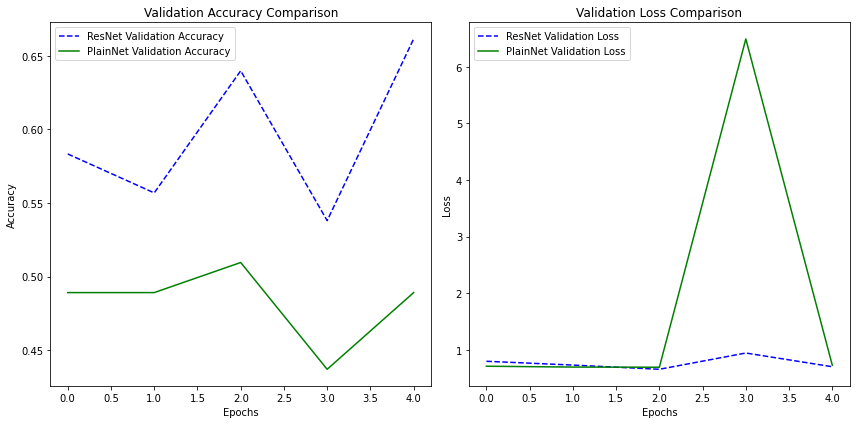

In [27]:
# 두 모델의 학습 history를 시각화합니다.
plot_history(resnet_50_history, plainnet_50_history)

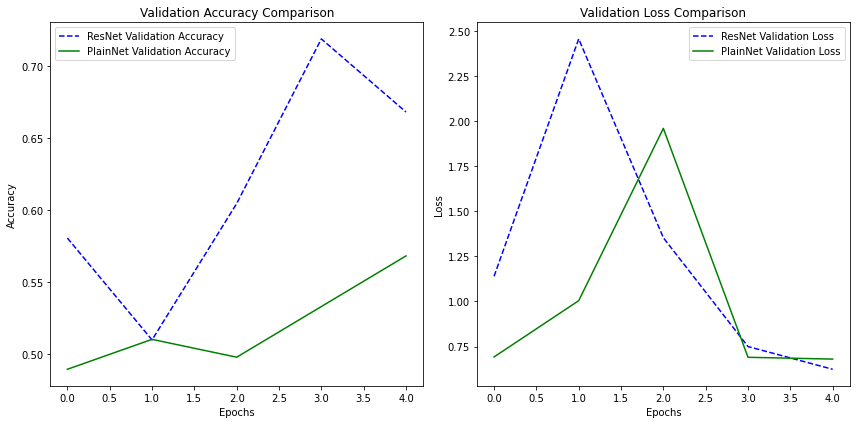

In [28]:
# 두 모델의 학습 history를 시각화합니다.
plot_history(resnet_34_history, plainnet_34_history)

# 회고

일단 그래프를 잘못그렸다.
논문에서 비교한 그림은 Resnet 30 vs 50, plain34vs 50이였다.

우리가 기존에 알고있는 지식으로예측해보면, 레이어의 수가 늘어나면 늘어날수록 성능이 좋아야 한다고 알고있는데, 논문 그래프를 살펴보면

성능이 떨어지는 것이 아닌 성능이 비슷한 것을 알 수 있다. 즉, 레이어의 수가 상관없이 성능이 비슷하다는 것이다.

이를 통해 알 수 있는 건 Gradient vanishing이 발생해 입력값 가까이에 붙어있는 레이어들의 그레디언트들이 소실되어서 영향을 못받는 것을 알 수 있고,

Resnet은 잔차연결을 통해 값을 계속 전달해줌으로써 그레디언트값이 소실되지 않게 하므로써, 레이어를 깊게 쌓아도 학습이 잘 될 수 있게 한다는 것을 알 수 있다.